# 一、导入相关库包

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch  # 张量库
import torch.nn.functional as Func  # 激活函数
import torch.nn as nn  # 神经网络模块
from sklearn.preprocessing import LabelEncoder # 标签编码
from torch.utils.data import DataLoader, TensorDataset # 数据加载器，数据集
import time # 计时器

# 二、数据导入和预处理

## 2.1 数据导入

In [49]:
# cora数据集导入
cora_path = '../dataset/cora/cora.content'
cora = pd.read_csv(cora_path, sep='\t', header=None)
cora_cites = pd.read_csv('../dataset/cora/cora.cites', sep='\t', header=None)
print('cora_cites:\n',cora_cites.head())
# print('cora:\n',cora.head())
# 将编号转换成0-2707，方便进行下下标索引
labelencoder = LabelEncoder()
cora[0] = labelencoder.fit_transform(cora[0])
print('cora:\n',cora.head())


cora_cites:
     0        1
0  35     1033
1  35   103482
2  35   103515
3  35  1050679
4  35  1103960
cora:
    0     1     2     3     4     5     6     7     8     9     ...  1425  \
0   462     0     0     0     0     0     0     0     0     0  ...     0   
1  1911     0     0     0     0     0     0     0     0     0  ...     0   
2  2002     0     0     0     0     0     0     0     0     0  ...     0   
3   248     0     0     0     0     0     0     0     0     0  ...     0   
4   519     0     0     0     0     0     0     0     0     0  ...     0   

   1426  1427  1428  1429  1430  1431  1432  1433                    1434  
0     0     1     0     0     0     0     0     0         Neural_Networks  
1     1     0     0     0     0     0     0     0           Rule_Learning  
2     0     0     0     0     0     0     0     0  Reinforcement_Learning  
3     0     0     0     0     0     0     0     0  Reinforcement_Learning  
4     0     0     0     0     0     0     0     0   P

## 2.2 数据预处理

In [50]:
# 定义初始化参数
N = cora.shape[0] # 节点数量，即数据集的行数
F = cora.shape[1] - 2 # 特征数量，即数据集的列数减去编号和标签两列
print('节点数量:', N)
print('特征数量:', F)
# 定义标签
labels = cora.iloc[:, -1].values
print('标签:\n', labels)
# 对标签进行热度编码
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
print('标签编码:\n', labels)

# 根据cites生成邻接矩阵
edges = np.array(cora_cites)
# 对edges进行处理，将边的两个节点的编号转换成0-2707
for i in range(edges.shape[0]):
    edges[i][0] = labelencoder.transform([edges[i][0]])[0]
    edges[i][1] = labelencoder.transform([edges[i][1]])[0]
print('edges:\n', edges)
# 创建邻接矩阵
adj_matrix = np.zeros((N, N))
# 根据边的信息初始化邻接矩阵，这里直接生成了对称矩阵，即无向图
for i in range(edges.shape[0]):
    adj_matrix[edges[i][0]][edges[i][1]] = 1
    adj_matrix[edges[i][1]][edges[i][0]] = 1
print('邻接矩阵:\n', adj_matrix)
# 将邻接矩阵保存到本地
np.savetxt('../output/cora/adj_matrix.txt', adj_matrix, fmt='%d')

节点数量: 2708
特征数量: 1433
标签:
 ['Neural_Networks' 'Rule_Learning' 'Reinforcement_Learning' ...
 'Genetic_Algorithms' 'Case_Based' 'Neural_Networks']
标签编码:
 [2 5 4 ... 1 0 2]
edges:
 [[   0   21]
 [   0  905]
 [   0  906]
 ...
 [1874 2586]
 [1876 1874]
 [1897 2707]]
邻接矩阵:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [51]:
# 将数据转化成tensor
features = torch.FloatTensor(cora.iloc[:, 1:1+F].values) # 这里features的大小是(2708, 1433)，即2708个节点，每个节点有1433个特征,F=1433,N=2708
labels = torch.LongTensor(labels) # 这里labels的大小是(2708,)，形状是N行1列的列向量数据序列
adj_matrix = torch.FloatTensor(adj_matrix) # 这里adj_matrix的大小是(2708, 2708) ，即N行N列的邻接矩阵
print('features:', features,'\nfeatures type:', type(features), '\nfeatures shape:', features.shape,'\n')
print('label:', labels, '\nlabel type:', type(labels), '\nlabel shape:', labels.shape,'\n')
print('adj_matrix:', adj_matrix, '\nadj_matrix type:', type(adj_matrix), '\nadj_matrix shape:', adj_matrix.shape,'\n')

features: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) 
features type: <class 'torch.Tensor'> 
features shape: torch.Size([2708, 1433]) 

label: tensor([2, 5, 4,  ..., 1, 0, 2]) 
label type: <class 'torch.Tensor'> 
label shape: torch.Size([2708]) 

adj_matrix: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) 
adj_matrix type: <class 'torch.Tensor'> 
adj_matrix shape: torch.Size([2708, 2708]) 



# 三、模型定义
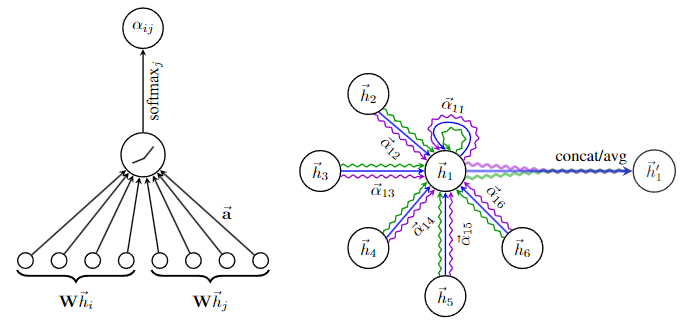

## 3.1 Transductive部分

![](https://img-blog.csdnimg.cn/direct/dc40ca5d422d4763a207c01435e72794.png)

Transductive Learning的部分，蓝色的部分是可以适用于Cora数据集和Citeseer数据集的模型参数；绿色部分是为了Pubmed数据集修改的参数：
- 第一层：
	- 多头注意力 K = 8 
	- 输出维度 F' = 8
	- 激活函数用 ELU
- 第二层：
	- 一个单注意力层
	- 输出只有一个attention head，如果是Pubmed则修改为8个
- 训练参数：
	- $\lambda$ = 0.0005，如果是Pubmed则修改成0.001
	- $p$ = 0.6

第一步计算：
$e_{ij}=a(\mathbf{W}\vec{h}_i,\mathbf{W}\vec{h}_j)$

第二步计算：
$\alpha_{ij}=\mathrm{softmax}_j(e_{ij})=\frac{\exp(e_{ij})}{\sum_{k\in\mathcal{N}_i}\exp(e_{ik})}.$

综合计算公式：
$\alpha_{ij}=\frac{\exp\left(\text{LeakyReLU}\left(\vec{\mathbf{a}}^T[\mathbf{W}\vec{h}_i\|\mathbf{W}\vec{h}_j]\right)\right)}{\sum_{k\in\mathcal{N}_i}\exp\left(\text{LeakyReLU}\left(\vec{\mathbf{a}}^T[\mathbf{W}\vec{h}_i\|\mathbf{W}\vec{h}_k]\right)\right)}$

In [52]:
class Gat_Layer(nn.Module):
    # in_feature就是F, out_feature就是F'
    def __init__(self, in_feature, out_feature, dropout, concat=True):
        super(Gat_Layer, self).__init__()
        self.in_feature = in_feature # 输入维度,这里维度是F*N
        self.out_feature = out_feature # 输出维度,这里是F' = 8
        # 定义网络层参数并初始化
        self.W = nn.Parameter(torch.zeros(size=(in_feature, out_feature))) #权重矩阵W,大小是F*F',这里换一下是因为在dataloader载入数据的时候相同的维度是N而不是F，行信息是N,而不是论文中所说的特征F
        self.alfa = nn.Parameter(torch.zeros(size=(2*out_feature, 1))) #权重列向量alfa,形状是2F'*1

        nn.init.xavier_uniform_(self.W.data, gain=1.414) # 使用xavier初始化方法初始化W，gain是用于计算权重的增益因子
        nn.init.xavier_uniform_(self.alfa.data, gain=1.414)

        # 定义LeakyRelu激活函数
        self.leakyrelu = nn.LeakyReLU(0.2)

        # dropout操作
        self.dropout = dropout
        self.concat = concat

    def forward(self, node_fearures, adj_nodes):
        # # 这里减少内存使用记h = W * h(输入)
        # Whi = torch.matmul(self.W, node_fearures) # [F',F] * [F,N] = [F',N]
        # Whj = Whi
        
        # # 这里遇到了需要遍历所有节点的问题，这里可以使用矩阵运算来解决
        # aWh = torch.matmul(self.alfa.T, torch.cat([Whi, Whj], dim=0)) # [1,2F'] * [2F',N] = [1,N]
        # e = self.leakyrelu(aWh) # [1,N],其中每个元素都是一个注意力系数，对应一个节点

        h = torch.matmul(node_fearures, self.W) # [N,F] * [F,F'] = [N,F']
        N = h.shape[0] # 节点数量

        # 计算注意力系数
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_feature)
        e = self.leakyrelu(torch.matmul(a_input, self.alfa).squeeze(2)) # [N,N]

        # 求邻接节点的注意力系数
        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj_nodes > 0, e, zero_vec)
        attention = Func.softmax(attention, dim=1)
        attention = Func.dropout(attention, self.dropout, training=self.training)

        # 更新节点特征
        h_prime = torch.matmul(attention, h)
        
        
        if self.concat:
            return Func.elu(h_prime)
        else:
            return h_prime

h'计算公式：
$\vec{h}_i'=\sigma\left(\sum_{j\in\mathcal{N}_i}\alpha_{ij}\mathbf{W}\vec{h}_j\right).$

用拼接的方法(这里求乘积的符号理解成||拼接)：
$\vec{h}_i'=\prod\limits_{k=1}^K\sigma\left(\sum\limits_{j\in\mathcal{N}_i}\alpha_{ij}^k\mathbf{W}^k\vec{h}_j\right)$

用计算平均值的方法：
$\vec{h}_i^{\prime}=\sigma\left(\frac1K\sum_{k=1}^K\sum_{j\in\mathcal{N}_i}\alpha_{ij}^k\mathbf{W}^k\vec{h}_j\right)$

根据单层的组合构建GAT网络架构

In [53]:
class GAT_Network(nn.Module):
	# 定义GAT网络架构
	# feature_num: 输入特征数量
	# out_feature: 输出特征数量
	# class_num: 分类数量
	# heads_num: 多头注意力数量
	# dropout: dropout概率,这里就是0.6
	def __init__(self, feature_num, out_feature, class_num, heads_num, dropout):
		super(GAT_Network, self).__init__()
		self.dropout = dropout
		# 定义多头注意力,实现的原理是将输入特征分成多个子特征，然后分别进行注意力计算，最后将结果拼接起来
		self.attention = [Gat_Layer(feature_num, out_feature, dropout) for _ in range(heads_num)]
		for i, attention in enumerate(self.attention):
			self.add_module('attention_{}'.format(i), attention) # 对应可视化图就是实现多个箭头指向中间那个节点用来计算注意力

		self.output = Gat_Layer(out_feature*heads_num, class_num, dropout) # 输出层，这里是将多头注意力的结果拼接起来，然后再进行分类 TODO:理解concat过程以及为什么要使用comcat和为什么不使用concat

	#TODO 理解这个forward函数
	def forward(self, node_features, adj_nodes):
		x = Func.dropout(node_features, self.dropout, training=self.training) # dropout操作
		x = torch.cat([att(node_features, adj_nodes) for att in self.attention], dim=1) # 将多头注意力的结果拼接起来
		x = Func.dropout(x, self.dropout, training=self.training) # dropout操作
		x = Func.elu(self.output(x, adj_nodes)) # 输出层，这里是将多头注意力的结果拼接起来，然后再进行分类
		return Func.log_softmax(x, dim=1) # softmax操作,这里使用的是log_softmax

## 3.2 Inductive Learning部分

![在这里插入图片描述](https://img-blog.csdnimg.cn/direct/4d8a4782d20c480e91ed2f37a26002c7.png)

Inductive Learning的部分，定义了三层的GAT模型，同时给出了参数设置：
- 前两层参数定义：
	- 多头注意力 K = 4
	- 输出维度 F' = 256
	- 激活函数 Func = ELU
- 后一层参数定义
	- 多头注意力 K = 6
	- 使用求平均的方法
	- 用sigmoid函数做激活函数
- 训练参数：
	- 数据量够大，不需要dropout
	- batch:2

In [54]:
# TODO 代码实现Inductive部分的代码

# 四、模型训练与测试

![在这里插入图片描述](https://img-blog.csdnimg.cn/direct/1fcb1cf54d7d4bddbef9017bf03f6929.png)

论文中给出了训练的参数设置如下：
- 初始化：使用Glorot初始化方法来初始化模型参数比如$W$权重矩阵和$\alpha$权重向量。
- 优化器：使用Adam SGD优化器
- 学习率：Pubmed是0.01，其他数据集是0.005
- 训练轮次：100

In [55]:
# 如果有GPU就使用GPU加速训练
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # 本电脑只有一个GPU
# 打印设备信息
print('device:', device)
torch.cuda.is_available()

device: cuda:0


True

模型定义

In [56]:
# 定义模型 
model = GAT_Network(
    feature_num=F, # 输入特征数量
    out_feature=8, # 输出特征数量
    class_num=7, # 分类数量
    heads_num=8, # 多头注意力数量
    dropout=0.6 # dropout概率
    ).to(device)

优化器定义

In [57]:
# 定义优化器
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.005, 
    weight_decay=5e-4
    ) # Adam优化器

模型训练

In [58]:
# 定义损失函数
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数

# 定义训练集和测试集
train_features = features
train_labels = labels
adj_matrix = adj_matrix.to(device)
# 定义数据加载器
train_loader = DataLoader(
    TensorDataset(train_features, train_labels), 
    batch_size=2708, # 一次性加载所有的数据，也就是一次性将图结构加载进来
    shuffle=True
    ) # 数据加载器

# 训练模型
model.train() # 训练模式
for epoch in range(100):
    t = time.time()
    for i, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(data, adj_matrix)
        loss = criterion(output, label) # 计算损失，这里是交叉熵损失
        loss.backward()
        optimizer.step()
    print('Epoch: {:04d}'.format(epoch+1), 'loss: {:.4f}'.format(loss.item()), 'time: {:.4f}s'.format(time.time()-t))



Epoch: 0001 loss: 2.0574 time: 1.0850s
Epoch: 0002 loss: 1.9513 time: 0.7530s
Epoch: 0003 loss: 1.9248 time: 0.8578s
Epoch: 0004 loss: 1.9453 time: 0.7556s
Epoch: 0005 loss: 1.8925 time: 0.7560s
Epoch: 0006 loss: 1.8710 time: 0.7557s
Epoch: 0007 loss: 1.8744 time: 0.7573s
Epoch: 0008 loss: 1.8541 time: 0.7520s
Epoch: 0009 loss: 1.8392 time: 0.7534s
Epoch: 0010 loss: 1.8387 time: 0.7512s
Epoch: 0011 loss: 1.8276 time: 0.7588s
Epoch: 0012 loss: 1.8021 time: 0.7516s
Epoch: 0013 loss: 1.8193 time: 0.7556s
Epoch: 0014 loss: 1.7886 time: 0.7532s
Epoch: 0015 loss: 1.7861 time: 0.7562s
Epoch: 0016 loss: 1.7779 time: 0.8409s
Epoch: 0017 loss: 1.7641 time: 0.7560s
Epoch: 0018 loss: 1.7558 time: 0.7520s
Epoch: 0019 loss: 1.7634 time: 0.7552s
Epoch: 0020 loss: 1.7448 time: 0.7542s
Epoch: 0021 loss: 1.7247 time: 0.7569s
Epoch: 0022 loss: 1.7282 time: 0.7546s
Epoch: 0023 loss: 1.7262 time: 0.7569s
Epoch: 0024 loss: 1.7258 time: 0.7518s
Epoch: 0025 loss: 1.7356 time: 0.7571s
Epoch: 0026 loss: 1.7296 

In [59]:
# 测试模型预测准确率
model.eval() # 测试模式
output = model(features.to(device), adj_matrix)
pred = output.max(1, keepdim=True)[1]
correct = pred.eq(labels.to(device).view_as(pred)).sum().item()
acc = correct / len(labels)
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.5366
